# Import Needed Packages

In [54]:
import calendar
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import boto3
import sagemaker
from sagemaker import get_execution_role
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

warnings.filterwarnings("ignore")

# Connect to S3 Bucket

In [3]:
# Get execution permissions
iam_role = get_execution_role()

In [4]:
# Specify Bucket Name
raw_data_bucket_name = "ads-508-spring2023-team3"

# Set up session parameters
session = boto3.session.Session()
region = session.region_name
sagemaker_session = sagemaker.Session()
personal_bucket = sagemaker_session.default_bucket()

# Establish an S3 connection
s3 = boto3.Session().client(service_name="s3", region_name=region)

In [5]:
# Set path to buckets (raw data and new personal bucket)
raw_data_path = 's3://{}'.format(raw_data_bucket_name)
personal_s3 = "s3://{}/london_data".format(personal_bucket)

In [6]:
# Check if connection to new personal s3 bucket was successfully established
try:
    bucket_contents = s3.list_objects(Bucket = personal_bucket)["Contents"]
    print("Connected to bucket successfully!\n")
    #print("Files in S3 bucket:")
    #for i in bucket_contents:
        #print(i["Key"])
except:
    # If connection failed, print error message
    print("##### ERROR #####")
    print("Could NOT connect to bucket: {} ({})".format(raw_data_bucket_name, personal_bucket))

Connected to bucket successfully!



In [7]:
# Create Unique Paths for Each CSV File
hourly_market_data_path = personal_s3 + "/market_data/Hourly_European_Market_Data.csv"
london_energy_path = personal_s3 + "/energy_data/London_Energy.csv"
london_weather_path = personal_s3 + "/weather_data/London_Weather_1979_2021.csv"

Athena will later create an external table based on the files of a bucket. Because all three files will act as a table for querying, all the files will need a unique path/folder.

# Copy Raw CSV Files to Personal S3 Bucket

In [8]:
!aws s3 cp --recursive $raw_data_path/ $hourly_market_data_path/ --exclude "*" --include "Hourly_European_Market_Data.csv"
!aws s3 cp --recursive $raw_data_path/ $london_energy_path/ --exclude "*" --include "London_Energy.csv"
!aws s3 cp --recursive $raw_data_path/ $london_weather_path/ --exclude "*" --include "London_Weather_1979_2021.csv"

copy: s3://ads-508-spring2023-team3/Hourly_European_Market_Data.csv to s3://sagemaker-us-east-1-510267762309/london_data/market_data/Hourly_European_Market_Data.csv/Hourly_European_Market_Data.csv
copy: s3://ads-508-spring2023-team3/London_Energy.csv to s3://sagemaker-us-east-1-510267762309/london_data/energy_data/London_Energy.csv/London_Energy.csv
copy: s3://ads-508-spring2023-team3/London_Weather_1979_2021.csv to s3://sagemaker-us-east-1-510267762309/london_data/weather_data/London_Weather_1979_2021.csv/London_Weather_1979_2021.csv


In [9]:
# Confirm that CSV files were copied to personal S3 bucket
!aws s3 ls $hourly_market_data_path/
!aws s3 ls $london_energy_path/
!aws s3 ls $london_weather_path/

2023-03-16 04:38:26  105185070 Hourly_European_Market_Data.csv
2023-03-16 04:38:28   95649585 London_Energy.csv
2023-03-16 04:38:30     814426 London_Weather_1979_2021.csv


# Create Athena Database

In [10]:
database_name = "london_data"

In [11]:
# Create a staging S3 directory - a temporary directory for querying
stage_dir = "s3://{}/athena/staging".format(personal_bucket)

In [12]:
# Connect to Staging Directory
try:
    pyathena_conn = connect(
        region_name = region, 
        s3_staging_dir = stage_dir)
    print("Connected to S3 staging directory!")
except:
    print("##### ERROR #####")
    print("##### Could NOT connect to S3 staging directory #####")

Connected to S3 staging directory!


In [13]:
# Create new Database - Print an error if there is a failure
try:
    sql_statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
    pd.read_sql(sql_statement, pyathena_conn)
    print("Database {} succesfully created!".format(database_name))
    sql_statement = "SHOW DATABASES"
    df_show = pd.read_sql(sql_statement, pyathena_conn)
    print(df_show.head(5))
except:
    print("##### ERROR #####")
    print("##### Could NOT create database #####")


Database london_data succesfully created!
  database_name
0       default
1        dsoaws
2   london_data


## Create Tables from CSV files

In [14]:
# SQL Create Table State from Hourly Market Data CSV
table_name = "hourly_european_market_data_csv"
path_to_data = personal_s3 + "/market_data"

csv_table_statement = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        Id int,
        Fecha date,
        Hora int,
        Sistema	string,
        Bandera	string,
        Precio float,
        Tipo_moneda	string,
        Origen_dato	string,
        Fecha_actualizacion	timestamp
    )
    ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
    LOCATION '{}'
    TBLPROPERTIES ('skip.header.line.count'='1')
    """.format(database_name, table_name, path_to_data)

# Execute Create Table Statement
pd.read_sql(csv_table_statement, pyathena_conn)
print("Succesfully made market_data table")

Succesfully made market_data table


In [15]:
# SQL Create Table State from Energy CSV
table_name = "london_weather_csv"
path_to_data = personal_s3 + "/weather_data"

csv_table_statement = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        LCLid string,
        Date date,
        Kwh float
    )
    ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
    LOCATION '{}'
    TBLPROPERTIES ('skip.header.line.count'='1')
    """.format(database_name, table_name, path_to_data)

# Execute Create Table Statement
pd.read_sql(csv_table_statement, pyathena_conn)
print("Successfully created energy_data table")

Successfully created energy_data table


In [16]:
# SQL Create Table State from Energy CSV
table_name = "london_energy_csv"
path_to_data = personal_s3 + "/energy_data"

csv_table_statement = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        Date string,
        Cloud_cover float,
        Sunshine float,
        Global_radiation float,
        Max_temp float,
        Mean_temp float,
        Min_temp float,
        Precipitation float,
        Pressure float,
        Snow_depth float
    )
    ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
    LOCATION '{}'
    TBLPROPERTIES ('skip.header.line.count'='1')
    """.format(database_name, table_name, path_to_data)

# Execute Create Table Statement
pd.read_sql(csv_table_statement, pyathena_conn)
print("Successfully created weather_data table")

Successfully created weather_data table


In [17]:
# Show Created Tables
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, pyathena_conn)
df_show.head(5)

,tab_name
0,hourly_european_market_data_csv
1,london_energy_csv
2,london_weather_csv


In [18]:
# Count rows to ensure that all rows were added to created tables
query = """
    SELECT COUNT(1)
    FROM {}.{}
    """.format(database_name, "hourly_european_market_data_csv")

pd.read_sql(query, pyathena_conn)

,_col0
0,1831555


In [19]:
query = """
    SELECT COUNT(1)
    FROM {}.{}
    """.format(database_name, "london_energy_csv")

pd.read_sql(query, pyathena_conn)

,_col0
0,3510433


In [20]:
query = """
    SELECT COUNT(1)
    FROM {}.{}
    """.format(database_name, "london_weather_csv")

pd.read_sql(query, pyathena_conn)

,_col0
0,15341


# Data Exploration in SQL via PyAthena

In [31]:
# Monthly average electricity price
query = """
    SELECT YEAR(fecha) AS Year,
        MONTH(fecha) AS Month,
        AVG(precio) AS Avg_Price
    FROM {}.hourly_european_market_data_csv
    GROUP BY YEAR(fecha), MONTH(fecha)
    ORDER BY YEAR(fecha), MONTH(fecha) asc;
    """.format(database_name)

monthly_avg_price = pd.read_sql(query, pyathena_conn)
monthly_avg_price.head(10)

,Year,Month,Avg_Price
0,2010,7,42.636627
1,2010,8,76.112564
2,2010,9,46.093450
3,2010,10,50.410633
4,2010,11,47.319530
5,2010,12,49.341072
6,2011,1,50.033813
7,2011,2,51.160927
8,2011,3,53.950410
9,2011,4,52.013780


In [36]:
avg_price.tail(5)

,Year,Month,Avg_Price,Date
134,2021,9,121.46419,2021-9
135,2021,10,138.86417,2021-10
136,2021,11,155.97880,2021-11
137,2021,12,209.28218,2021-12
138,2022,1,138.87798,2022-1


In [55]:
# Modify output
avg_price = monthly_avg_price
# Merge Year and month to create a date column
avg_price["Date"] = avg_price["Year"].map(str) + '-' + avg_price["Month"].map(str)

# Create a Month_name column
avg_price["Month_name"] = avg_price["Month"].apply(lambda x: calendar.month_abbr[x])

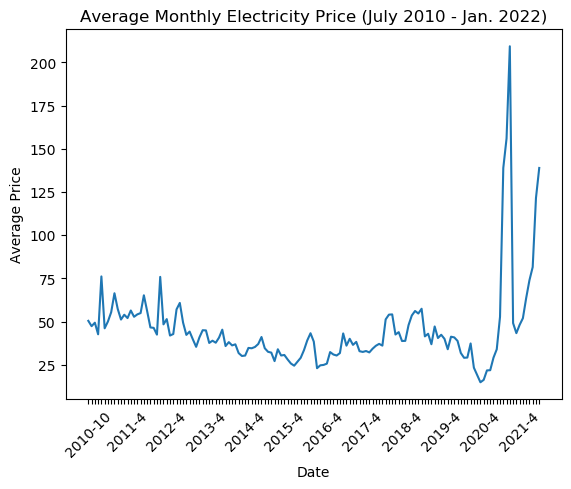

In [56]:
# Plot of monthly average electricity price
ax = plt.gca()
sns.lineplot(
    data = avg_price, 
    x = "Date", y = "Avg_Price")
for index, label in enumerate(ax.get_xticklabels()):
   if index % 12 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
plt.xticks(rotation=45)
plt.ylabel("Average Price")
plt.title("Average Monthly Electricity Price (July 2010 - Jan. 2022)")
plt.show()

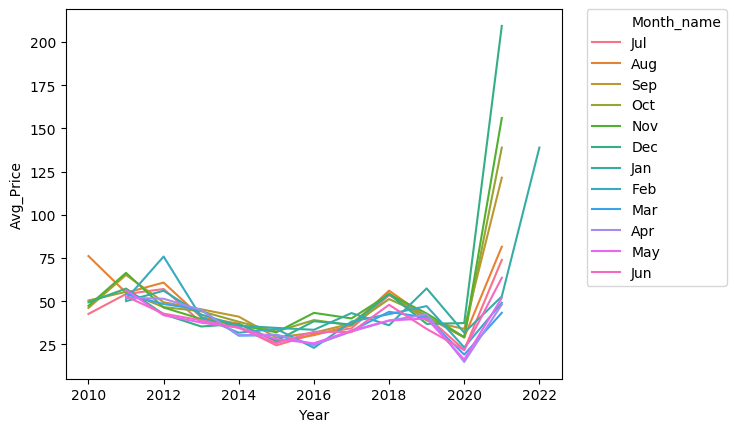

In [61]:
# Plot Monthly Average Price of Electricity Across Years
sns.lineplot(
    data = avg_price,
    x = "Year", y = "Avg_Price",
    hue = "Month_name")
plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left", borderaxespad = 0)
plt.show()

- Ingest raw data to Athena and trim the data to all be within the same time frame
- Export the data back out to S3

# Release Resources

In [26]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [27]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>